In [72]:
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime

## Titel



In [73]:


# Regex patterns to find the timestamp, pin status, and expensive hours
status_pattern = re.compile(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}).*Pin (\d+).*?(actief|aan)')
heatpump_hours_pattern = re.compile(r"Heatpump - day_ahead_hours today \(already chosen\): \[\[(.*?)\]\]")
boiler_hours_pattern = re.compile(r"Gekozen Uren met prijs: \[(.*?)\]")

def extract_hours_boiler(hours_str):
    # Extract hour numbers using a regular expression to find 'hour' and 'price' pairs
    boiler_hours = re.findall(r"'hour': '(\d+)'", hours_str)
    return list(map(int, boiler_hours))

# Function to extract just the hour numbers from the heatpump log format
def extract_hours_heatpump(hours_str):
    heatpump_hours = re.findall(r"'(\d+)'", hours_str)
    return list(map(int, heatpump_hours))

def parse_log_file(file_path):
    data = {'timestamp': [], 'pin': [], 'status': [], 'boiler_expensive': [], 'heatpump_expensive': []}
    boiler_expensive_hours = set()
    heatpump_expensive_hours = set()
    
    with open(file_path, 'r') as file:
        for line in file:
            # Match and extract heatpump specific expensive hours
            match_heatpump_hours = heatpump_hours_pattern.search(line)
            if match_heatpump_hours:
                heatpump_expensive_hours.update(extract_hours_heatpump(match_heatpump_hours.group(1)))
                
            # Match and extract general boiler expensive hours
            match_boiler_hours = boiler_hours_pattern.search(line)
            if match_boiler_hours:
                boiler_expensive_hours.update(extract_hours_boiler(match_boiler_hours.group(1)))

            # Match and extract device status updates
            match_status = status_pattern.search(line)
            if match_status:
                timestamp = datetime.strptime(match_status.group(1), '%Y-%m-%d %H:%M:%S')
                pin = match_status.group(2)
                status = 0 if 'actief' in match_status.group(3) else 1  # Assuming 'actief' means active/running
                boiler_exp = timestamp.hour in boiler_expensive_hours
                heatpump_exp = timestamp.hour in heatpump_expensive_hours
                data['timestamp'].append(timestamp)
                data['pin'].append(pin)
                data['status'].append(status)
                data['boiler_expensive'].append(boiler_exp)
                data['heatpump_expensive'].append(heatpump_exp)
    
    df = pd.DataFrame(data)
    return df

# Parse the log file and get the DataFrame
log_file_path = '/home/pi/Automation/ESunAutomation/logs/runlogs/log_2023-11-06.log'
df = parse_log_file(log_file_path)


In [74]:
# Separate the data for each pin
df_heatpump = df[df['pin'] == '31'].copy()
df_boiler = df[df['pin'] == '29'].copy()

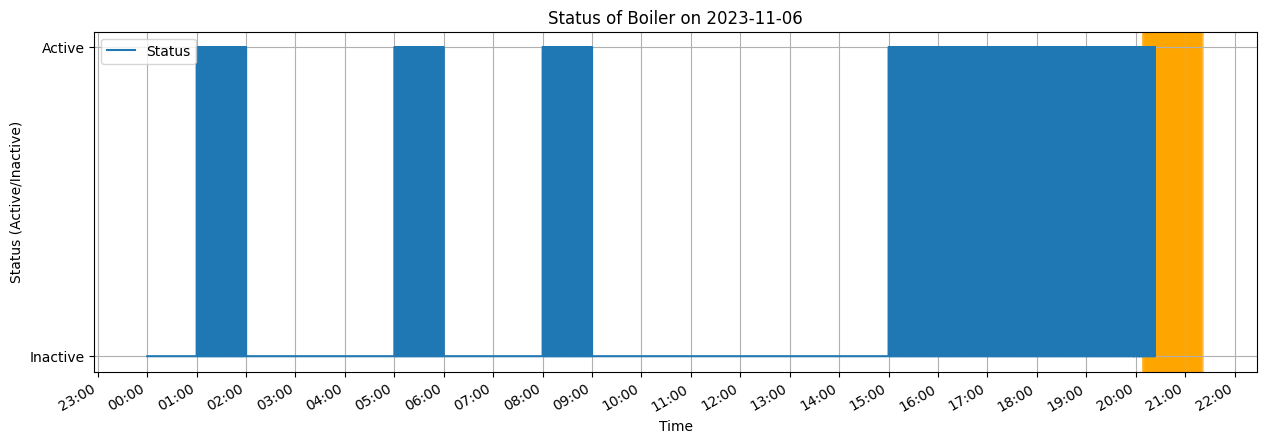

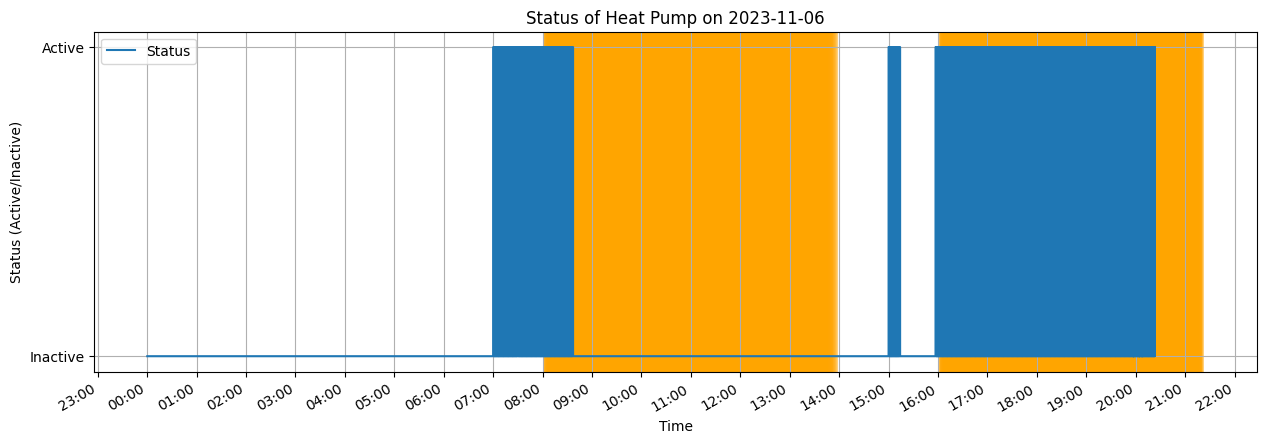

In [75]:
def plot_device_data(df, device_name, expensive_column):
    # Make sure 'timestamp' is the index and is in datetime format
    df.set_index('timestamp', inplace=True)

    # Create a plot
    plt.figure(figsize=(15, 5))
    plt.plot(df.index, df['status'], drawstyle='steps-post', label='Status')

    # Highlight expensive hours
    for time in df[df[expensive_column]].index:
        plt.axvspan(time, time + pd.Timedelta(hours=1), facecolor='orange', alpha=0.3)

    # Set x-axis major locator and formatter
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Rotate date labels to prevent overlap
    plt.gcf().autofmt_xdate()

    # Include the date in the title
    date_str = df.index[0].strftime('%Y-%m-%d')
    plt.title(f'Status of {device_name} on {date_str}')

    plt.xlabel('Time')
    plt.ylabel('Status (Active/Inactive)')
    plt.yticks([0, 1], ['Inactive', 'Active'])
    plt.legend()
    plt.grid(True)
    plt.show()

# To use the function for the boiler:
plot_device_data(df_boiler, 'Boiler', 'boiler_expensive')

# And for the heat pump:
plot_device_data(df_heatpump, 'Heat Pump', 'heatpump_expensive')
